In [1]:
import pandas as pd
from statistics import mean
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##### Data Processing

In [2]:
mat = pd.read_csv("mat.csv")
por = pd.read_csv("por.csv")

In [3]:
joined = pd.merge(mat, por, on = ["school","sex","age","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet","Dalc","goout","freetime","famrel", "studytime","traveltime","failures","paid","address","romantic"])

In [4]:
joined["mat_percent"] = (joined["G1_x"] + joined["G2_x"] + joined["G3_x"])*100/60
joined["port_percent"] = (joined["G1_y"] + joined["G2_y"] + joined["G3_y"])*100/60
joined["port_fail"] = joined["port_percent"] < 60
joined["mat_fail"] = joined["mat_percent"] < 60
joined["fail"] = joined["port_fail"] | joined["mat_fail"]
joined["absences"] = joined["absences_y"] + joined["absences_x"]
(joined["fail"] == False).mean()

0.3333333333333333

###### Descriptive Stats

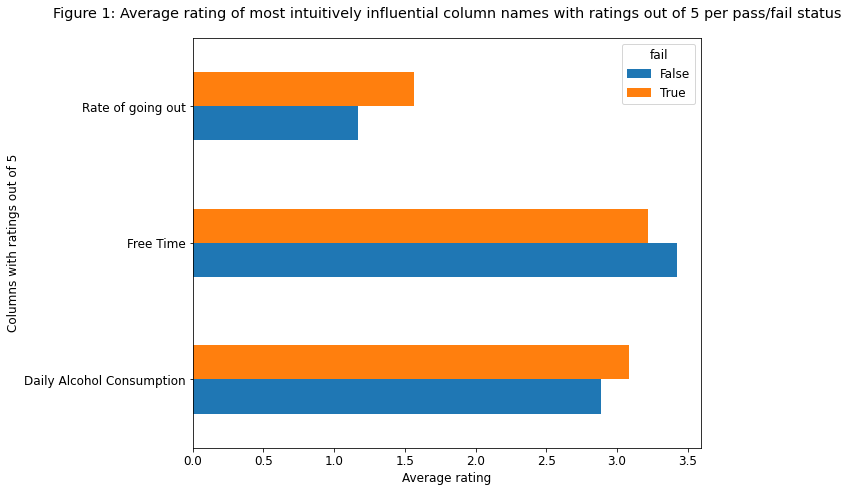

In [5]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize = (10,7))
q1 = joined[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid","fail"]]
q1 = q1.groupby("fail").mean()[["goout", "freetime", "Dalc"]]
q1.columns = ["Daily Alcohol Consumption", "Free Time", "Rate of going out"]
ax = q1.T.plot.barh(ax = ax)
ax.set_title("Figure 1: Average rating of most intuitively influential column names with ratings out of 5 per pass/fail status", pad=20)
ax.set_ylabel("Columns with ratings out of 5")
ax.set_xlabel("Average rating")
plt.tight_layout()
plt.savefig('fig1.png', bbox_inches='tight')

##### Unsupervised Learning

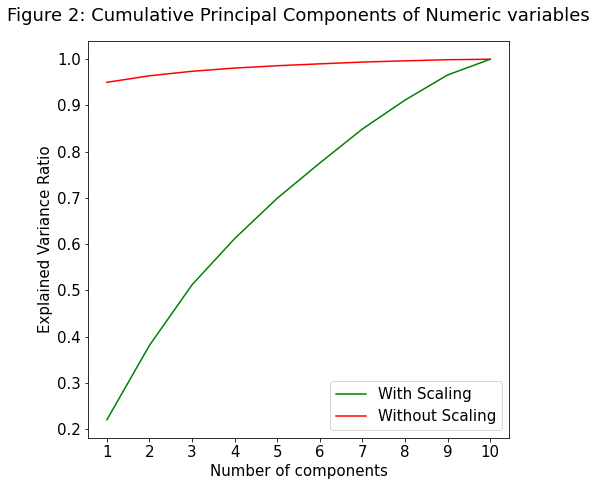

In [6]:

q2 = {}
for i in range(1,11):
    pca = PCA(n_components = i)
    vals = pca.fit_transform(joined[["Medu","Fedu", "goout", "freetime","Dalc", "absences","age","studytime", "traveltime", "failures"]])
    q2[i] = sum(pca.explained_variance_ratio_)

q2_s = {}
scaler = StandardScaler()
scaler.fit(joined[["Medu","Fedu", "goout", "freetime","Dalc", "absences","age","studytime", "traveltime", "failures"]])
for i in range(1,11):
    pca = PCA(n_components = i)
    vals = pca.fit_transform(scaler.transform(joined[["Medu","Fedu", "goout", "freetime","Dalc", "absences","age","studytime", "traveltime", "failures"]]))
    q2_s[i] = sum(pca.explained_variance_ratio_)

q2_s  = pd.DataFrame(q2_s, index = [i for i in range(1,11)]).T
q2_s = q2_s[[1]]
q2_s["Number of Components"] = [i for i in range(1,11)]
q2_s.columns = ["With Scaling", "Number of Components"]
q2  = pd.DataFrame(q2, index = [i for i in range(1,11)]).T
q2 = q2[[1]]
q2["Number of Components"] = [i for i in range(1,11)]
q2.columns = ["Without Scaling", "Number of Components"]
var = pd.merge(q2_s, q2, on = "Number of Components")
var = var.set_index("Number of Components")
plt.rcParams["font.size"] = 15
fig, ax = plt.subplots(figsize= (7,7))
ax = var.plot.line(ax = ax, color = ["g", "r"])
ax.xaxis.set_ticks(np.arange(1,11,1))
ax.set_title("Figure 2: Cumulative Principal Components of Numeric variables", pad=20)
ax.set_ylabel("Explained Variance Ratio")
ax.set_xlabel("Number of components")
plt.tight_layout()
plt.savefig('fig2.png', bbox_inches='tight')

###### Train the ML model

In [7]:
cols = ["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","fail","studytime","traveltime","failures","paid"]

In [8]:
train, test = train_test_split(joined[cols], test_size = 0.30, random_state = 0)

In [9]:
train.shape

(113, 20)

In [10]:
  Pipe = Pipeline([("both", make_column_transformer(
                (OneHotEncoder(), ["address","famsize","Mjob","Fjob","internet","romantic","Pstatus","paid"]),
      (PolynomialFeatures(degree = 2), ["Medu","Fedu", "goout", "freetime","Dalc", "absences","age","studytime", "traveltime", "failures"]),
      remainder="passthrough")),
                   
            ("lr",LogisticRegression()),
         ])

In [11]:
Pipe.fit(train[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]], train["fail"])

/home/neilbhutada/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('both',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['address', 'famsize', 'Mjob',
                                                   'Fjob', 'internet',
                                                   'romantic', 'Pstatus',
                                                   'paid']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  ['Medu', 'Fedu', 'goout',
                                                   'freetime', 'Dalc',
                                                   'absences', 'age',
                                                   'studytime', 'traveltime',
                                                   'fai

In [12]:
Pipe.score(test[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]], test["fail"])
predictions = Pipe.predict(test[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]])

In [13]:
cm = metrics.confusion_matrix(test["fail"], predictions, labels = [True, False])

In [14]:
len(["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"])

19

In [15]:
Pipe.score(test[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]], test["fail"])

0.7551020408163265

In [16]:
cm[0,0]/(cm[0,0]+cm[0,1])

0.88

In [17]:
cm[0,0]/(cm[0,0]+cm[1,0])

0.7096774193548387

In [18]:
2*(cm[0,0]/(cm[0,0]+cm[0,1]))*(cm[0,0]/(cm[0,0]+cm[1,0]))/((cm[0,0]/(cm[0,0]+cm[0,1]))+(cm[0,0]/(cm[0,0]+cm[1,0])))

0.7857142857142856

In [19]:
roc_auc_score(test["fail"], Pipe.decision_function(test[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]]))

0.7633333333333333

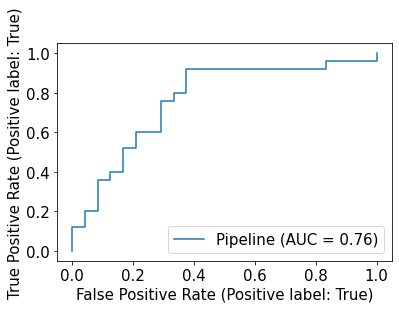

In [20]:
metrics.plot_roc_curve(Pipe, test[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]], test["fail"]) 

In [21]:
a = cross_val_score(Pipe, train[["address","famsize","Mjob","Fjob","Medu","Fedu","internet","goout","freetime","famrel","romantic","Dalc","Pstatus","absences","age","studytime","traveltime","failures","paid"]], train["fail"], cv=5)
a.var()

/home/neilbhutada/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/neilbhutada/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

0.0074527019637863415

##### Plotting model coefficients

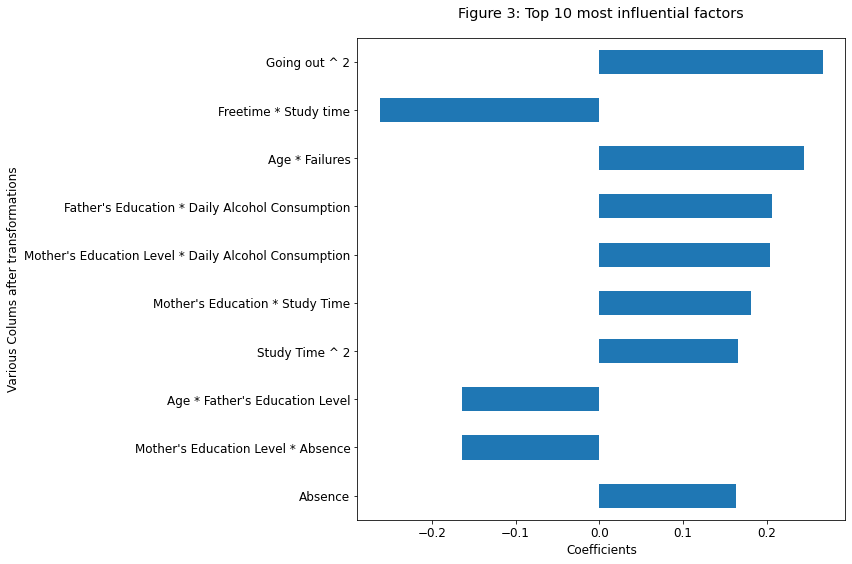

In [24]:
cols = Pipe['both'].get_feature_names()
q3 = pd.Series(Pipe['lr'].coef_[0], index= cols).sort_values(key = abs)[-10:]
q3.index = ["Absence", "Mother's Education Level * Absence", "Age * Father's Education Level", "Study Time ^ 2", "Mother's Education * Study Time", "Mother's Education Level * Daily Alcohol Consumption", "Father's Education * Daily Alcohol Consumption","Age * Failures", "Freetime * Study time", "Going out ^ 2"]
plt.rcParams["font.size"] = 12
fig , ax = plt.subplots(figsize = (12,8))
ax = q3.plot.barh()
ax.set_title("Figure 3: Top 10 most influential factors", pad=20)
ax.set_xlabel("Coefficients")
ax.set_ylabel("Various Colums after transformations")
plt.tight_layout()
plt.savefig('fig3.png', bbox_inches='tight')